# Story 7 - Where Do Strategic Minerals Come From?

---

CUNY DATA 608

Spring 2024

# Overview

Strategic minerals are critical to the economy and national security of the United States. These materials are essential for a wide range of critical technologies and industries, including renewable energy, automobile manufacturing, defense systems, and telecommunications. The diversity of strategic minerals, such as rare earth elements, lithium, which is required for advanced battery technology, and cobalt, which is required for aerospace engineering, highlights their importance across multiple sectors. The United States relies heavily on an intricate global supply chain to secure these minerals, navigating a landscape fraught with geopolitical complexities. The concentration of these resources in specific global regions creates additional layers of dependency that may jeopardize the country's technological sovereignty and economic stability. In this context, understanding the intricate web of supply sources, as well as assessing their stability and reliability, is critical.

This report examines the sourcing of strategic minerals, categorizing import sources according to their geopolitical alignment with the United States as allies, competitors, or neutrals. The report identifies potential supply chain vulnerabilities and assesses the risks posed by geopolitical tensions or economic disruptions using detailed scenario analysis and comprehensive visualizations. The overarching goal is to provide insights and strategic recommendations to strengthen the resilience of the US supply chain, ensuring long-term access to these critical materials while supporting ongoing technological innovation and strategic independence.

# 1. Data Preparation

## 1.1 Load data

The dataset was obtained from the CIA World Factbook's section on strategic materials. Strategic material names and import sources were scraped from specified HTML tags using Python requests and the BeautifulSoup library. The extracted data was cleaned and compiled into a pandas DataFrame, categorizing materials alongside their respective import sources, and then saved to a CSV file for further analysis. This structured format enables a thorough examination of global material sourcing.

In [22]:
# @title
# Load libraries
import csv
import requests
from bs4 import BeautifulSoup
import pandas as pd
import re
import plotly.express as px
import geopandas as gpd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import seaborn as sns
from geopandas import GeoDataFrame
import plotly.graph_objects as go
import numpy as np
import folium

In [23]:
# @title
# URL of the website to scrape
url = 'https://www.cia.gov/the-world-factbook/references/strategic-materials/'

# Send a GET request to the URL
response = requests.get(url)
response.raise_for_status()

soup = BeautifulSoup(response.content, 'html.parser')

material_names = []
import_sources = []

# Iterate through each h3 tag and find the 4th next sibling that's a p tag
for h3_tag in soup.find_all('h3'):
    # Initialize the variable to hold the p tags
    p_tag = h3_tag

    # Loop to skip 3 p tags
    for _ in range(4):
        p_tag = p_tag.find_next_sibling('p')
        if not p_tag:
            break  # Exit the loop if there are no more p tags

    # If we found the 4th p tag with 'Import Sources', proceed to extract the text
    if p_tag and 'Import Sources' in p_tag.text:
        material_name = h3_tag.get_text(strip=True)
        import_sources_text = p_tag.text.replace('Import Sources (2018-21):', '').strip()
        material_names.append(material_name)
        import_sources.append(import_sources_text)

    # If we found the 4th p tag with 'Import sources', proceed to extract the text
    if p_tag and 'Import sources' in p_tag.text:
        material_name = h3_tag.get_text(strip=True)
        import_sources_text = p_tag.text.replace('Import sources (2018-21):', '').strip()
        material_names.append(material_name)
        import_sources.append(import_sources_text)

# Iterate through each h3 tag
for h3_tag in soup.find_all('h3'):
    # Initialize the variable to hold the p tags
    p_tag = h3_tag

    for _ in range(3):
      p_tag = p_tag.find_next_sibling('p')
      if not p_tag:
        break  # Exit the loop if there are no more p tags

    # If we found the 3rd p tag with 'Import Sources (2018-21):', proceed to extract the text
    if p_tag and 'Import Sources (2018-21):' in p_tag.text:
        material_name = h3_tag.get_text(strip=True)
        import_sources_text = p_tag.find_all('em')[1].next_sibling.strip()
        import_sources_text = p_tag.text.strip()
        import_sources_text = import_sources_text.split('Import Sources (2018-21):')[-1].strip()
        material_names.append(material_name)
        import_sources.append(import_sources_text)

# Create a df
df = pd.DataFrame({
    'Strategic Material': material_names,
    'Import Sources': import_sources
})

# Save df to CSV
csv_filename = 'strategic_materials_import_sources.csv'
df.to_csv(csv_filename, index=False)

# Load the CSV into a df
load_df = pd.read_csv('strategic_materials_import_sources.csv')

## 1.2 Summary Statistics

The dataset contains information on 50 strategic materials, including the import sources for each. This data is organized in a pandas DataFrame with two columns, 'Strategic Material' and 'Import Sources'. The 'Strategic Material' column contains the names of the materials, while the 'Import Sources' column lists the countries and their percentages of each material's imports. No data is missing in this dataset.

In [24]:
# @title
load_df.info(),
load_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Strategic Material  50 non-null     object
 1   Import Sources      50 non-null     object
dtypes: object(2)
memory usage: 928.0+ bytes


,Strategic Material,Import Sources
0,Barite or Barium Sulfate (BaSO4),"China, 38%; India, 29%; Morocco, 16%; Mexico, ..."
1,Fluorspar or Calcium Fluoride (CaF2),"Mexico, 66%; Vietnam, 16%; South Africa, 7%; C..."
2,Potash (potassium-containing compounds such as...,"Canada, 79%; Russia, 9%; Belarus, 7%; and othe..."
3,Aluminum (Al/13),"Bauxite: Jamaica, 63%; Brazil, 9%; Guyana and ..."
4,Antimony (Sb/51),"Ore and concentrates: China, 46%; Italy, 34%; ..."


## 1.3 Data cleaning

The data preparation started with the initial extraction focused on specific HTML tags to capture strategic mineral names and their import sources from the website. This involved navigating through the web page's structural elements to accurately locate and retrieve the desired content.

After the data was extracted, it went through a series of cleaning steps. This included removing unnecessary text, correcting formatting errors, and breaking down complex data strings into more structured forms that clearly defined each country and its contribution to import percentages. As a result, instead of a raw web data we got a clean, structured format suitable for analysis.

The cleaned data was then loaded into a pandas DataFrame and organized into a tabular format with columns for each strategic material and its corresponding sources. To improve the analytical value of the data, additional processing steps were implemented. This included categorizing import sources as allies, competitors, or neutrals based on their geopolitical stance toward the United States, categorizing material types as metals, compounds, non-metals, precious metals, or rare earth elements, adding ISO codes to the data to evaluate supply chain risks and dependencies.

In [25]:
# @title
# Define the cleaning instructions for each material
cleaning_instructions = {
    'Aluminum (Al/13)': ('Alumina: ', True),
    'Antimony (Sb/51)': ('oxide: ', True),
    'Bismuth (Bi/83)': (': ', True),
    'Chromium (Cr/24)': ('Total imports: ', True),
    'Copper (Cu/29)': ('Refined copper: ', True),
    'Nickel (Ni/28)': ('. Nickel-containing scrap', False),
    'Niobium (Nb/41)': ('Ferroniobium and niobium metal: ', True),
    'Rhenium (Re/75)': ('imports: ', True),
    'Strontium (Sr/38)': ('imports: ', True),
    'Tantalum (Ta/73)': ('Total: ', True),
    'Titanium (Ti/22)': ('. Titanium', False),
    'Vanadium (V/23)': ('Total: ', True),
    'Zinc (Zn/30)': ('metal: ', True),
    'Zirconium (Zr/40)': ('. Zirconium, unwrought:', False),
    'Selenium (Se/34)': ('. Selenium dioxide:', False),
    'Silicon (Si/14)': ('Total: ', True),
    'Cerium (Ce/58)': ('; Compounds', False),
    'Yttrium (Y/39)': ('. Nearly', False)
}

# Function to clean the 'Import Sources' based on the cleaning instructions
def clean_import_sources(row, material, split_on, keep_after):
    if row['Strategic Material'] == material:
        parts = row['Import Sources'].split(split_on, 1)
        return parts[-1] if keep_after else parts[0]
    return row['Import Sources']

# Apply the cleaning function to each row in the dataframe based on the material
for material, (split_on, keep_after) in cleaning_instructions.items():
    load_df['Import Sources'] = load_df.apply(clean_import_sources, axis=1, args=(material, split_on, keep_after))

load_df.loc[load_df['Strategic Material'] == 'Copper (Cu/29)', 'Import Sources'] = load_df[load_df['Strategic Material'] == 'Copper (Cu/29)']['Import Sources'].apply(lambda x: x.split('. Refined', 1)[-2])
load_df.loc[load_df['Strategic Material'] == 'Niobium (Nb/41)', 'Import Sources'] = load_df[load_df['Strategic Material'] == 'Niobium (Nb/41)']['Import Sources'].apply(lambda x: x.split('. Total imports: ', 1)[-2])
load_df.loc[load_df['Strategic Material'] == 'Gallium (Ga/31)', 'Import Sources'] = load_df[load_df['Strategic Material'] == 'Gallium (Ga/31)']['Import Sources'].apply(lambda x: x.split('metal - ', 1)[-1])

# Replace specific shared percentage strings
corrections = {
    "Australia and Jamaica, 14% each": "Australia, 14%; Jamaica, 14%",
    "Germany and Japan, 13% each": "Germany, 13%; Japan, 13%",
    "Estonia and Japan, 5% each": "Estonia, 5%; Japan, 5%",
    "China,6 24%;": "China, 24%; ",
    "China,7 9%": "China, 9%",
    "South Korea 1%": "South Korea, 1%",
    "Italy, 8%, Germany, 8%;": "Italy, 8%; Germany, 8%;",
    "Ukraine, 1%, and": "Ukraine, 1%; and",
    "Russia, 3%, Germany, 1%, and": "Russia, 3%; Germany, 1%; and"
}

for old, new in corrections.items():
    load_df['Import Sources'] = load_df['Import Sources'].str.replace(old, new, regex=False)

# Filter out unwanted materials
unwanted_materials = ['Cesium (Cs/55)', 'Rubidium (Rb/37)', 'Scandium (Sc/21)']
load_df = load_df[~load_df['Strategic Material'].isin(unwanted_materials)]

In [26]:
# @title
# Copy df
df_text_fix = load_df.copy()

# Function to clean the 'Import Sources' column
def clean_import_sources(text):
    # Remove everything before the first country, including any leading descriptions and colon
    text = re.sub(r'^.*?:', '', text)
    # Remove the word 'and' before 'other'
    text = re.sub(r'\band\b', '', text)
    # Remove specific unwanted prefixes
    text = re.sub(r'Piezoelectric quartz - ', '', text)
    text = re.sub(r'<', '', text)
    # Replace " and " before "other" with a comma
    text = re.sub(r'\band\b', '', text)
    # Strip extra whitespace that may be left before or after the text
    text = text.strip()
    return text

# Function to remove text inside parentheses
def remove_parentheses(text):
    # Use a regular expression to remove any text inside parentheses
    return re.sub(r'\(.*?\)', '', text).strip()

# Apply the function to the 'Import Sources' column
df_text_fix['Import Sources'] = df_text_fix['Import Sources'].apply(clean_import_sources)
# Apply the function to the 'Strategic Material' column
df_text_fix['Strategic Material'] = df_text_fix['Strategic Material'].apply(remove_parentheses)

# Create a mapping for material to category
material_to_category = {
    'Aluminum': 'Metals', 'Antimony': 'Metals', 'Bismuth': 'Metals', 'Cadmium': 'Metals',
    'Chromium': 'Metals', 'Cobalt': 'Metals', 'Copper': 'Metals', 'Gallium': 'Metals',
    'Indium': 'Metals', 'Lead': 'Metals', 'Lithium': 'Metals', 'Magnesium': 'Metals',
    'Manganese': 'Metals', 'Mercury': 'Metals', 'Molybdenum': 'Metals', 'Nickel': 'Metals',
    'Niobium': 'Metals', 'Rhenium': 'Metals', 'Strontium': 'Metals', 'Tantalum': 'Metals',
    'Tin': 'Metals', 'Titanium': 'Metals', 'Tungsten': 'Metals', 'Uranium': 'Metals', 'Vanadium': 'Metals',
    'Zinc': 'Metals', 'Zirconium': 'Metals', 'Platinum': 'Precious Metals',
    'Silver': 'Precious Metals', 'Palladium': 'Precious Metals', 'Cerium': 'Rare Earth Elements',
    'Yttrium': 'Rare Earth Elements', 'Arsenic': 'Non-metals', 'Boron': 'Non-metals',
    'Germanium': 'Non-metals', 'Graphite / Carbon': 'Non-metals', 'Helium': 'Non-metals',
    'Natural Rubber': 'Non-metals', 'Quartz Crystal': 'Non-metals', 'Selenium': 'Non-metals',
    'Silicon': 'Non-metals', 'Tellurium': 'Non-metals', 'Barite or Barium Sulfate': 'Compounds',
    'Fluorspar or Calcium Fluoride': 'Compounds', 'Potash': 'Compounds', 'Beryllium': 'Metals',
    'Hafnium': 'Metals'
}

# Map the categories to the materials in the dataframe
df_text_fix['Material Category'] = df_text_fix['Strategic Material'].map(material_to_category)

df_text_fix.head()

,Strategic Material,Import Sources,Material Category
0,Barite or Barium Sulfate,"China, 38%; India, 29%; Morocco, 16%; Mexico, ...",Compounds
1,Fluorspar or Calcium Fluoride,"Mexico, 66%; Vietnam, 16%; South Africa, 7%; C...",Compounds
2,Potash,"Canada, 79%; Russia, 9%; Belarus, 7%; other, 5%",Compounds
3,Aluminum,"Brazil, 59%; Australia, 14%; Jamaica, 14%; Can...",Metals
4,Antimony,"China, 63%; Belgium, 8%; India, 7%; other, 22%",Metals


In [27]:
# @title
# Copy df
df_split = df_text_fix.copy()

# Expand the 'Import Sources' into multiple rows split by ';'
# Create a df with each country-percentage pair on a new row
s = df_split['Import Sources'].str.split(';').explode().str.strip()

# Modify the regex to be more robust and include percentages with decimal
df_expanded = s.str.extract(r'(?P<Country>[^,]+),\s*(?P<Percentage>\d+\.?\d*)%')

# Join the expanded data back with the original df on the index
minerals_df = df_split.join(df_expanded, how='left')

# Convert 'Percentage' to numeric, ensuring decimals are handled properly
minerals_df['Percentage'] = pd.to_numeric(minerals_df['Percentage'], errors='coerce')

# Drop the original 'Import Sources' column if it's no longer needed
minerals_df.drop(columns=['Import Sources'], inplace=True)

# Fix counrty name
minerals_df['Country'] = minerals_df['Country'].str.replace("Cote d’Ivoire", "Cote d'Ivoire", regex=False)
minerals_df['Country'] = minerals_df['Country'].str.replace("South Korea", "Republic of Korea", regex=False)

minerals_df.head()

,Strategic Material,Material Category,Country,Percentage
0,Barite or Barium Sulfate,Compounds,China,38.0
0,Barite or Barium Sulfate,Compounds,India,29.0
0,Barite or Barium Sulfate,Compounds,Morocco,16.0
0,Barite or Barium Sulfate,Compounds,Mexico,13.0
0,Barite or Barium Sulfate,Compounds,other,4.0


In [28]:
# @title
# Define the categorization of countries
ally_countries = [
    'Australia', 'Belgium', 'Canada', 'France', 'Germany', 'Italy',
    'Japan', 'Norway', 'Poland', 'Spain', 'Republic of Korea', 'Mexico', 'Israel', 'Taiwan', 'Ukraine']
competitor_countries = ['China', 'Russia', 'Belarus']

# Function to categorize each country
def categorize_country(country):
    if country in ally_countries:
        return 'Ally'
    elif country in competitor_countries:
        return 'Competitor'
    else:
        return 'Neutral'

# Apply the categorization function to the dataset
minerals_df['Category'] = minerals_df['Country'].apply(categorize_country)

minerals_df.loc[(minerals_df['Strategic Material'] == 'Natural Rubber') & (minerals_df['Country'] == 'other'), 'Percentage'] = 6.0
minerals_df.loc[(minerals_df['Strategic Material'] == 'Uranium') & (minerals_df['Country'] == 'other'), 'Percentage'] = 10.4
minerals_df.loc[(minerals_df['Strategic Material'] == 'Mercury') & (minerals_df['Country'] == 'other'), 'Percentage'] = 0.0

In [29]:
# @title
# Manual mapping might be necessary if country names don't match exactly with common geo datasets
country_to_iso = {'China': 'CHN',
 'India': 'IND',
 'Morocco': 'MAR',
 'Mexico': 'MEX',
 'other': 'other',
 'Vietnam': 'VNM',
 'South Africa': 'ZAF',
 'Canada': 'CAN',
 'Russia': 'RUS',
 'Belarus': 'BLR',
 'Brazil': 'BRA',
 'Australia': 'AUS',
 'Jamaica': 'JAM',
 'Belgium': 'BEL',
 'Republic of Korea': 'KOR',
 'Germany': 'GER',
 'Peru': 'PER',
 'Kazakhstan': 'KAZ',
 'Norway': 'NOR',
 'Finland': 'FIN',
 'Japan': 'JPN',
 'Chile': 'CHL',
 'Ukraine': 'UKR',
 'France': 'FRA',
 'Argentina': 'ARG',
 'Israel': 'ISR',
 'Taiwan': 'TWN',
 'Gabon': 'GAB',
 'Indonesia': 'IDN',
 'Bolivia': 'BOL',
 'Malaysia': 'MYS',
 'Namibia': 'NAM',
 'Spain': 'ESP',
 'Senegal': 'SEN',
 'Switzerland': 'SUI',
 'Italy': 'ITA',
 'Poland': 'POL',
 'Turkey': 'TUR',
 'Madagascar': 'MDG',
 'Qatar': 'QAT',
 'Algeria': 'ALG',
 'Thailand': 'THA',
 "Cote d'Ivoire": 'CIV',
 'Liberia': 'LBR',
 'Philippines': 'PHI',
 'Estonia': 'EST',
 'Latvia': 'LVA'}

# Map ISO codes to the minerals data
minerals_df['iso_a3'] = minerals_df['Country'].map(country_to_iso)

# Display the updated df
minerals_df.head()

,Strategic Material,Material Category,Country,Percentage,Category,iso_a3
0,Barite or Barium Sulfate,Compounds,China,38.0,Competitor,CHN
0,Barite or Barium Sulfate,Compounds,India,29.0,Neutral,IND
0,Barite or Barium Sulfate,Compounds,Morocco,16.0,Neutral,MAR
0,Barite or Barium Sulfate,Compounds,Mexico,13.0,Ally,MEX
0,Barite or Barium Sulfate,Compounds,other,4.0,Neutral,other


# 2. Data analysis

Each mineral in the US strategic inventory is sourced from a different region, each with its own political and economic stability characteristics. For example, the Democratic Republic of the Congo, a major supplier of cobalt used in battery technology, is classified as neutral but unstable, posing the risk of supply disruption due to political unrest.

The comprehensive world map depicts the countries from which the US obtains strategic minerals. Countries are colored green, red, and gray to represent allies, competitors, and neutrals. For example, significant amounts of rare earth elements are imported from China and Russia, which are labeled red, highlighting a dependency that may become problematic as diplomatic relations worsen. Furthermore, Russia and China are major suppliers of palladium and antimony, both of which are used in electronics and alloys, accounting for 34% and 63% of US imports, respectively. In contrast, aluminum supplies from Australia, an ally, appear to be a more secure supply line given current geopolitical alignments.

The pie chart divides U.S. mineral imports into three categories: allies, competitors, and neutrals, with allies accounting for 36.4%, competitors for 15.1%, and neutrals for 48.4%, respectively. While the high proportion of neutral countries is not immediately concerning, it does include countries with varying degrees of political and economic stability, which could quickly become less reliable in crisis situations. While the reliance on competitors is smaller, it is concentrated in critical areas such as the supply of rare earth elements from China and nickel from Russia—materials needed for advanced electronics and energy solutions. This configuration poses a strategic risk in the event of geopolitical tensions or trade disputes, as these countries may manipulate mineral supplies to implement political or economic pressure.

The bar chart depicts the United States' reliance on strategic materials obtained primarily from competitor countries. For example, China provides more than 60% of the United States' supply of antimony, which is used in flame retardants and lead-acid batteries. This detailed view provides a better understanding of which materials are most vulnerable to supply disruption, which could have serious consequences for key industries.

To evaluate the vulnerability of the US supply chain, we look at several detailed scenarios in which supply disruptions could have serious consequences:

- During a trade dispute, China imposes export restrictions on rare earth elements, which has the potential to disrupt markets. Rare earth elements are critical in the production of high-performance electronics, military radar, and jet engines. A disruption could cause delays in defense procurement, increase costs for consumer electronics manufacturers, and potentially shut down large segments of the technology industry. As a result, the United States may need to seek alternative sources from allies such as Australia and Canada, invest in rare earth element recycling technologies, and fund R&D for synthetic alternatives.

- The Democratic Republic of the Congo is experiencing a severe political crisis, which has forced the closure of major cobalt mines. Cobalt is essential for aerospace alloys and batteries. A shortage could cripple production lines for major US aerospace and EV manufacturers, with serious economic consequences. As a result, the United States may need to broaden its cobalt supply to include more stable regions, improve cobalt recycling from used electronics and batteries, and encourage the development of cobalt-free battery technology.
-------

*Not all critical minerals are listed here. Dysprosium, erbium, europium gadolinium, iridium, holmium, lanthanum,
lutetium, praseodymium, samarium, thulium, neodymium, terbium, cesium,	rubidium, ruthenium, scandium and ytterbium are not shown because there was not enough information available regarding sources*

In [12]:
# @title
# Load world geometry from a local file or geopandas dataset
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Merge the minerals data with the world data
world = world.merge(minerals_df, left_on='iso_a3', right_on='iso_a3', how='left')

# Remove rows with no data on strategic minerals
world = world.dropna(subset=['Category'])

# Assuming you have latitude and longitude set for the center of your map
map_center_lat, map_center_lon = 0, 0

# Create a Folium map
m = folium.Map(
    location=[map_center_lat, map_center_lon],  # Center the map on the equator and prime meridian
    zoom_start=2,      # Set the initial zoom level for the map
    min_zoom=2,        # Restrict the map zoom-out level
    max_bounds=True    # Ensure the map cannot be panned beyond the world's borders
)

# Define colors for categories
colors = {'Ally': '#77dd77', 'Competitor': '#ff6961', 'Neutral': '#cfcfc4'}

# Add GeoJson to Folium map
folium.GeoJson(
    world,
    style_function=lambda feature: {
        'fillColor': colors[feature['properties']['Category']],
        'color': 'black',
        'weight': 0.5,
        'dashArray': '5, 5',
        'fillOpacity': 0.7,
    },
    tooltip=folium.GeoJsonTooltip(
        fields=['name', 'Strategic Material', 'Percentage', 'Category'],
        aliases=['Country', 'Strategic Material', 'Percentage', 'Category'],
        localize=True
    )
).add_to(m)

m.fit_bounds(m.get_bounds())

# Display map
m

<ipython-input-12-9b9137e2efdf>:3: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


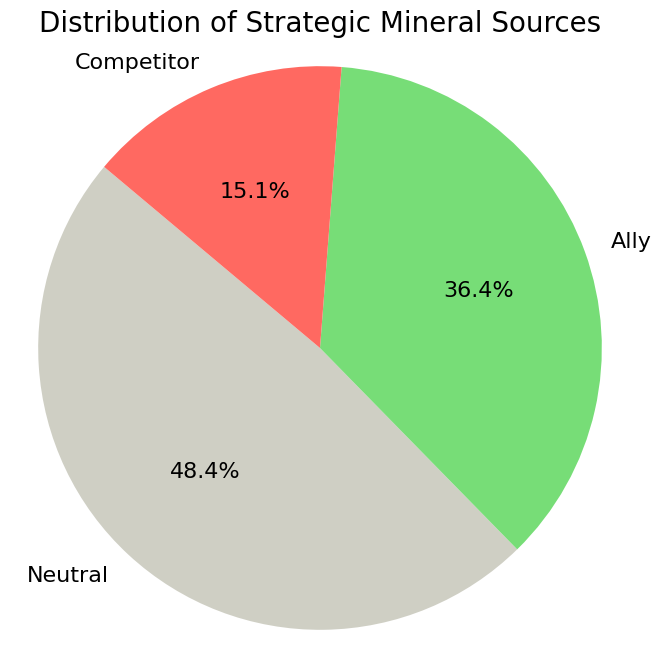

In [13]:
# @title
# Summarize data for pie chart
country_summary = minerals_df['Category'].value_counts()


# Generate pie chart
plt.figure(figsize=(8, 8))
plt.pie(country_summary, labels=country_summary.index, autopct='%1.1f%%', startangle=140, colors=['#cfcfc4', '#77dd77', '#ff6961'], textprops={'fontsize': 16})
plt.title('Distribution of Strategic Mineral Sources', size=20)
plt.axis('equal')

plt.show()

In [14]:
# @title
# Create a pivot table to summarize the percentages by Strategic Material and Category
dependency_data = minerals_df.pivot_table(index='Strategic Material', columns='Category', values='Percentage', aggfunc='sum', fill_value=0)
dependency_data = dependency_data[['Competitor', 'Neutral', 'Ally']]
dependency_data = dependency_data.sort_values('Competitor')

# Create the horizontal stacked bar chart using Plotly
fig = go.Figure()
categories = ['Competitor', 'Neutral', 'Ally']
colors=['#ff6961', '#cfcfc4', '#77dd77']

# Filter materials with high dependency on competitor countries (>50%)
high_risk_materials = dependency_data[dependency_data['Competitor'] > 50]

for category, color in zip(categories, colors):
    fig.add_trace(go.Bar(
        name=category,
        x=high_risk_materials[category],
        y=high_risk_materials.index,
        orientation='h',
        marker=dict(color=color)
    ))

fig.update_layout(
    barmode='stack',
        title={
        'text': "<b>Strategic Materials with >50% Dependency on Competitor Countries</b>",
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top',
        'font': dict(size=20, family="Arial, sans-serif")},
    xaxis=dict(
        title='Percentage of Total Supply',
        titlefont=dict(size=18),
        tickfont=dict(size=14)),
    yaxis=dict(
        title='Strategic Material',
        titlefont=dict(size=18),
        tickfont=dict(size=14)),
    legend_title=dict(
        text='Country Category',
        font=dict(size=16)),
    legend=dict(x=1.05, y=1),
    width=1000,
    height=1000,
            font=dict(
            family="Arial, sans-serif"
        )
)

# Show the plot
fig.show()

# Conclusion

This report emphasizes the critical need for a multifaceted approach to securing the US's strategic mineral supply. To address the identified risks, we recommend:

- Use diplomacy to secure new mining contracts with less geopolitically sensitive countries, while fortifying existing relationships with reliable allies.

- Invest in domestic infrastructure to reduce reliance on foreign sources, especially high-risk minerals.

- To reduce raw material demand, encourage research and development of alternative materials to replace strategic minerals, as well as recycling.

- Establish or expand national reserves of critical minerals to mitigate short-term supply disruptions.

- Implement policies that promote sustainable and secure mineral sourcing, such as incentives for domestic exploration and development and regulations that improve supply chain transparency.

The strategic importance of ensuring a reliable and secure supply of essential minerals cannot be overstated. The complexities of global mineral supply chains necessitate proactive and coordinated policy responses to prevent disruptions. Implementing these recommendations will help the United States strengthen its economic and national security posture, ensuring resilience in the face of global changes and uncertainties.

# References

1) U.S. Geological Survey releases 2022 list of critical minerals | U.S. Geological Survey. (n.d.). https://www.usgs.gov/news/national-news-release/us-geological-survey-releases-2022-list-critical-minerals

2) World Factbook Glyph. (n.d.). https://www.cia.gov/the-world-factbook/references/strategic-materials/#alloy

3) United States Department of Commerce. (2022). Critical and Strategic Minerals importance to the U.S. economy [Report]. https://smenet.blob.core.windows.net/smecms/sme/media/smeazurestorage/about%20sme/technical%20briefings/criticalmineralsfinal-01182022.pdf

4) Conte, N. (2023, August 4). Charted: America’s Import Reliance of Critical Minerals. Elements by Visual Capitalist. https://elements.visualcapitalist.com/americas-import-reliance-of-critical-minerals-charted/